In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
X_train = np.arange(10).reshape((10,1))
y_train = np.array(
    [1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0]
)

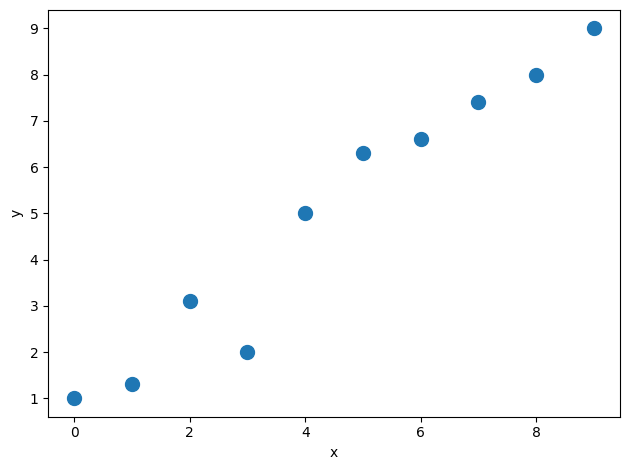

In [3]:
import matplotlib.pyplot as plt

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()

원본 데이터의 모습

이를 선형회귀 훈련을 시킬것이다.

In [22]:
from sklearn.preprocessing import StandardScaler
# 표준화 방법 1
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_train_std

array([[-1.5666989 ],
       [-1.21854359],
       [-0.87038828],
       [-0.52223297],
       [-0.17407766],
       [ 0.17407766],
       [ 0.52223297],
       [ 0.87038828],
       [ 1.21854359],
       [ 1.5666989 ]])

In [23]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32), tf.cast(y_train, tf.float32)))
# 표준화 방법 2

In [24]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()         # 케라스 모델을 MyModel클래쓰에 상속시킨다.
        self.w = tf.Variable(0.0, name='weight')# 그렇게 상속된 모델의 가중치
        self.b = tf.Variable(0.0, name='bias')  # 상속된 모델의 편향

    def call(self, x):                          # 이 모델이 입력데이터를 통해 출력데이터를 만드는 과정.                          
        return self.w * x + self.b              # 가중치 * 특성값 + 편향 = z

In [25]:
model = MyModel()
model.build(input_shape=(None, 1)) # 첫번째 차원 none, 두번째 1
model.summary()     # 이 메서드는 층마다의 모델 구성요소를 요약하고, 파라미터 개수를 알려준다.
                    # 호출을 위해선 먼저 특생개수를 지정해야한다.

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# 손실함수, 오차제곱합
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b]) # 가중치, 편향 그레디언트 게산
    model.w.assign_sub(learning_rate * dW)  # 가중치 업데이트
    model.b.assign_sub(learning_rate * db)  # 편향 업데이트

In [27]:
tf.random.set_seed(1)
num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train)/ batch_size))
ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)
Ws, bs = [], []

In [28]:
for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        # 무한반복 중지
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)
    train(model, bx, by, learning_rate=learning_rate)
    if i % log_steps == 0:
        print('epochs {:3d} step {:4d} 손실 {:6.4f}'
              .format(int(i/steps_per_epoch), i, loss_val))



epochs   0 step    0 손실 43.5600
epochs  10 step  100 손실 0.7530
epochs  20 step  200 손실 20.1759
epochs  30 step  300 손실 23.3976
epochs  40 step  400 손실 6.3481
epochs  50 step  500 손실 4.6356
epochs  60 step  600 손실 0.2411
epochs  70 step  700 손실 0.2036
epochs  80 step  800 손실 3.8177
epochs  90 step  900 손실 0.9416
epochs 100 step 1000 손실 0.7035
epochs 110 step 1100 손실 0.0348
epochs 120 step 1200 손실 0.5404
epochs 130 step 1300 손실 0.1170
epochs 140 step 1400 손실 0.1195
epochs 150 step 1500 손실 0.0944
epochs 160 step 1600 손실 0.4670
epochs 170 step 1700 손실 2.0695
epochs 180 step 1800 손실 0.0020
epochs 190 step 1900 손실 0.3612


최종 파라미터 :  2.6576622 4.8798566


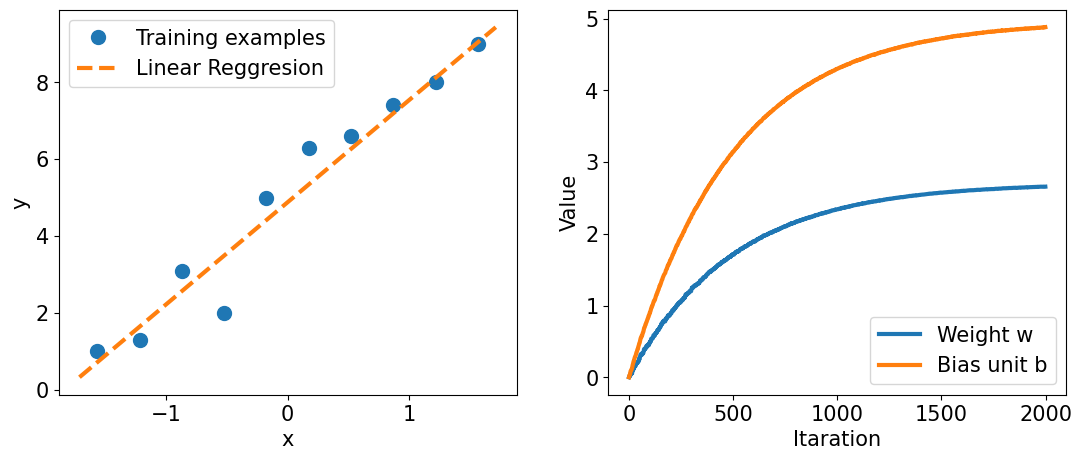

In [29]:
print('최종 파라미터 : ', model.w.numpy(), model.b.numpy())
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_test))/np.std(X_test)
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reggresion'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Itaration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()


위는 직접 train()함수를 만들고, 확률적 경사 하강법 최적화를 적용해서 모델을 훈련한 과정이다. 이제부터는 API 모델의 fit, compile 메서드를 이용해서 편리하고 빠르게 같은 과정을 수행할것이다.

In [30]:
tf.random.set_seed(1)
model = MyModel()
model.compile(
    optimizer='sgd',  # SGD 최적화 알고리즘 사용
    loss=loss_fn,     # 사용자가 정의한 손실 함수 사용
    metrics=['mae', 'mse']  # MAE와 MSE를 성능 평가 지표로 사용
)
model.fit(X_train_norm, y_train,
          epochs=num_epochs,
          batch_size=batch_size,
          verbose=1)

Epoch 1/200
10/10 [==============================] - 0s 812us/step - loss: 27.8723 - mae: 4.5654 - mse: 27.8723
Epoch 2/200
10/10 [==============================] - 0s 595us/step - loss: 18.6586 - mae: 3.7446 - mse: 18.6586
Epoch 3/200
10/10 [==============================] - 0s 491us/step - loss: 12.5239 - mae: 3.0454 - mse: 12.5239
Epoch 4/200
10/10 [==============================] - 0s 502us/step - loss: 8.4670 - mae: 2.4907 - mse: 8.4670
Epoch 5/200
10/10 [==============================] - 0s 562us/step - loss: 5.7632 - mae: 2.0567 - mse: 5.7632
Epoch 6/200
10/10 [==============================] - 0s 428us/step - loss: 3.9697 - mae: 1.7232 - mse: 3.9697
Epoch 7/200
10/10 [==============================] - 0s 650us/step - loss: 2.7766 - mae: 1.4752 - mse: 2.7766
Epoch 8/200
10/10 [==============================] - 0s 444us/step - loss: 1.9861 - mae: 1.2578 - mse: 1.9861
Epoch 9/200
10/10 [==============================] - 0s 468us/step - loss: 1.4572 - mae: 1.0978 - mse: 1.4572
Epoc

최종 파라미터 :  2.7067394 4.9657216
4/4 [==============================] - 0s 957us/step


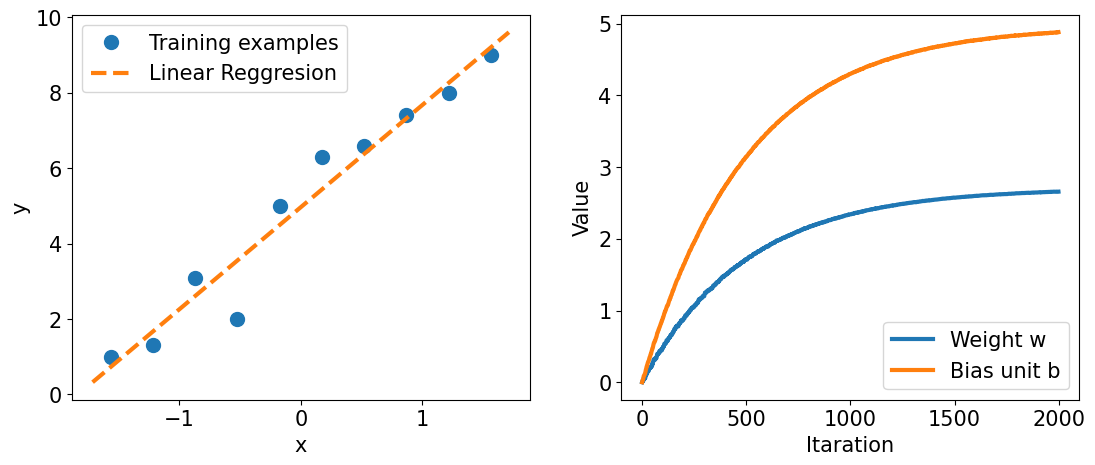

In [31]:
print('최종 파라미터 : ', model.w.numpy(), model.b.numpy())
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_test))/np.std(X_test)
y_pred = model.predict(tf.cast(X_test_norm, dtype=tf.float32))
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reggresion'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Itaration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()
